In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from mpl_toolkits.mplot3d import Axes3D
from keras.regularizers import l2
import seaborn as sns
import time

# Editing the data

In [2]:
!gdown 1sukAZPeouBnaMaa_NndiV2cWbwbE9fx3
data=pd.read_csv('/content/Boiler_emulator_dataset.txt',delimiter=",")
data.head()

Downloading...
From: https://drive.google.com/uc?id=1sukAZPeouBnaMaa_NndiV2cWbwbE9fx3
To: /content/Boiler_emulator_dataset.txt
100% 1.34M/1.34M [00:00<00:00, 153MB/s]


,Fuel_Mdot,Tair,Treturn,Tsupply,Water_Mdot,Condition,Class
0,1,283,333.0,363.574744,3.0,%=0.05,Lean
1,1,283,333.0,362.349517,3.0,%=0.1,Nominal
2,1,283,333.0,361.216941,3.0,%=0.15,ExcessAir
3,1,283,333.0,360.166890,3.0,%=0.20,ExcessAir
4,1,283,333.0,359.190662,3.0,%=0.25,ExcessAir


In [3]:
replacements = {'Nominal': 0, 'Lean': 1, 'ExcessAir': 2, 'Fouling': 3,'Scaling' : 4,'%=0.05' : 0.05, '%=0.1': 0.1, '%=0.15': 0.15,
                '%=0.20': 0.2, '%=0.25' : 0.25, '%=0.3': 0.3, '%=0.35': 0.35, '%=0.40': 0.4,  '%=0.45': 0.45, '%=0.50': 0.5, 'F = 0.01': 0.01,
                'F = 0.06': 0.06, 'F = 0.11': 0.11, 'F = 0.16': 0.16, 'F = 0.21': 0.21, 'F = 0.26': 0.26, 'F = 0.31': 0.31, 'F = 0.36': 0.36,
                'F = 0.41': 0.41, 'F = 0.46': 0.46, 'S = 0.01': 0.01,'S = 0.06': 0.06, 'S = 0.11': 0.11, 'S = 0.16': 0.16, 'S = 0.21': 0.21,
                'S = 0.26': 0.26, 'S = 0.31': 0.31, 'S = 0.36': 0.36,'S = 0.41': 0.41, 'S = 0.46': 0.46 }

data=data.replace(replacements)
data.to_csv('/content/data.csv', index=False)

* Labeling

In [4]:
normal=data.values[data['Class'].values==0]
normal=normal[:,0:6]
y0=np.zeros(len(normal))
lean=data.values[data["Class"].values==1]
lean=lean[:,0:6]
y1=np.ones(len(lean))
excess_air=data.values[data["Class"].values==2]
excess_air=excess_air[:,0:6]
y2=2*np.ones(len(excess_air))
fouling=data.values[data["Class"].values==3]
fouling=fouling[:,0:6]
y3=3*np.ones(len(fouling))
scaling=data.values[data["Class"].values==4]
scaling=scaling[:,0:6]
y4=4*np.ones(len(scaling))

In [5]:
X=np.concatenate([normal, lean, excess_air, fouling, scaling])
y=np.concatenate([y0, y1, y2, y3, y4])

* Filling nan/null with mean

In [6]:
df = pd.DataFrame(X)
df.fillna(df.mean(), inplace=True)
X = df.values

* The correlation

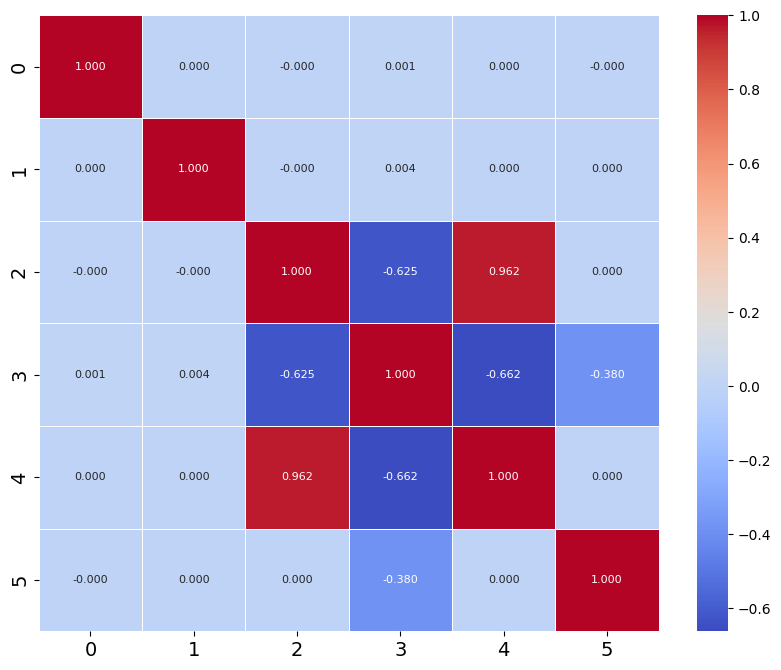

In [7]:
corrM = df.corr()
plt.figure(figsize=(10,8))
import seaborn as sn
sn.heatmap(corrM, annot=True ,cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8}, fmt='.3f', yticklabels=corrM.columns)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# LDA

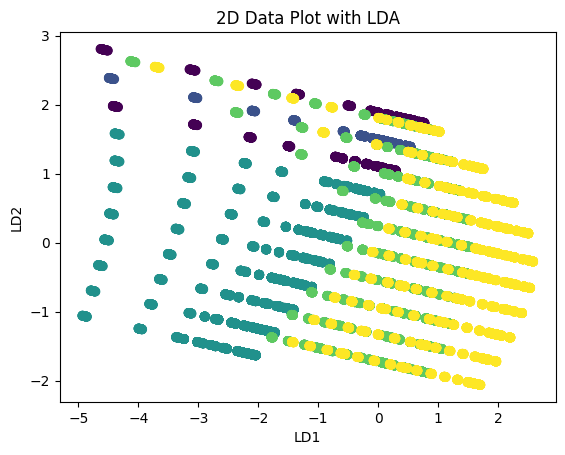

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Apply LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y)

# Create a 2D plot
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('2D Data Plot with LDA')
plt.show()


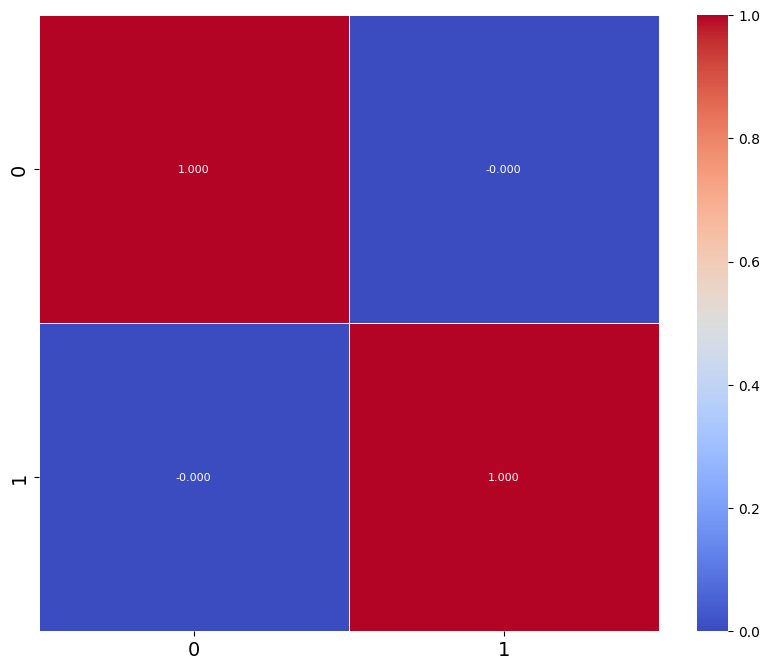

In [9]:
x_embeded= pd.DataFrame(X_lda)
corrM = x_embeded.corr()
plt.figure(figsize=(10,8))
import seaborn as sn
sn.heatmap(corrM, annot=True ,cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8}, fmt='.3f')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# KNN

In [21]:
from collections import Counter
import numpy as np
from scipy.spatial import cKDTree

class KNNClassifier:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.tree = cKDTree(X)

    def predict(self, X):
        _, indices = self.tree.query(X, k=self.k)
        k_labels = self.y_train[indices]
        y_pred = np.array([Counter(labels).most_common()[0][0] for labels in k_labels])
        return y_pred


## with scaler

In [22]:
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, confusion_matrix, accuracy_score
K=np.arange(2, 100, 1)
accuracies=[]
MARs=[]
FARs=[]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

for i,ki in enumerate(K):
  MAR=0
  FAR=0
  knn = KNNClassifier(k=ki)
  knn.fit(X_train,y_train)
  y_pred = knn.predict(X_test)
  conf_k = confusion_matrix(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy)

  TP = np.diag(conf_k)
  FN = np.sum(conf_k, axis=1) - TP
  FP = np.sum(conf_k, axis=0) - TP
  TN = np.sum(conf_k) - TP - FP - FN
  MAR = np.mean(FN / (FN + TP))
  FAR = np.mean((FP + np.transpose(FP)) / (FP + np.transpose(FP) + TN))
  MARs.append(MAR)
  FARs.append(FAR)




The Maximum accuracy is for k=9 with acc=0.7910557184750733


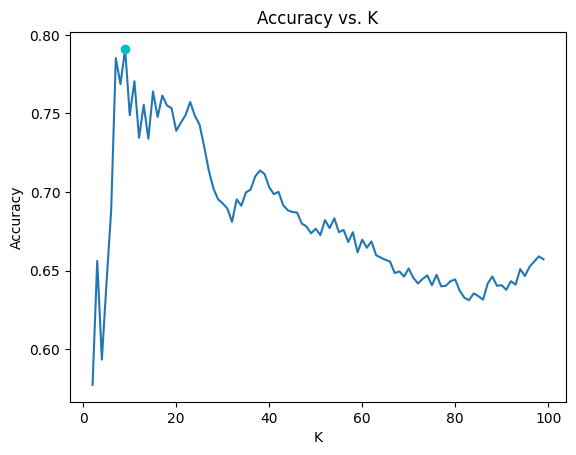

In [23]:
print("The Maximum accuracy is for k={0} with acc={1}".format(K[np.argmax(accuracies)],np.max(accuracies)))
fig, ax = plt.subplots()
plt.plot(K, accuracies)
plt.plot(K[np.argmax(accuracies)],np.max(accuracies),'co')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K')
# plt.legend()
plt.show()

Test AUC: 0.7986175872465239
Test Recall: 0.7910557184750733
Test F1-score: 0.7910557184750733
Test Precision: 0.7910557184750733
Confusion Matrix:


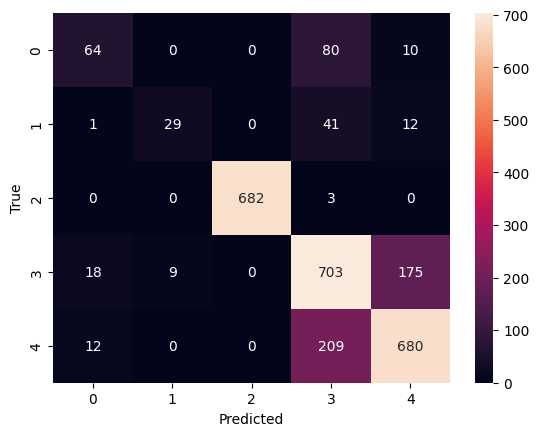

In [24]:
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, confusion_matrix
from keras.utils import to_categorical

knn1 = KNNClassifier(k=9)
knn1.fit(X_train,y_train)
y_pred = knn1.predict(X_test)

y_pred_classes = np.round(y_pred)
y_pred_classes = to_categorical(y_pred_classes, 5)
y_test_classes= to_categorical(y_test, 5)

auc_score = roc_auc_score(y_test_classes, y_pred_classes, multi_class='ovr')
recall = recall_score(y_test_classes, y_pred_classes, average='micro')
f1 = f1_score(y_test_classes, y_pred_classes, average='micro')
precision = precision_score(y_test_classes, y_pred_classes, average='micro')
print('Test AUC:', auc_score)
print('Test Recall:', recall)
print('Test F1-score:', f1)
print('Test Precision:', precision)


cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

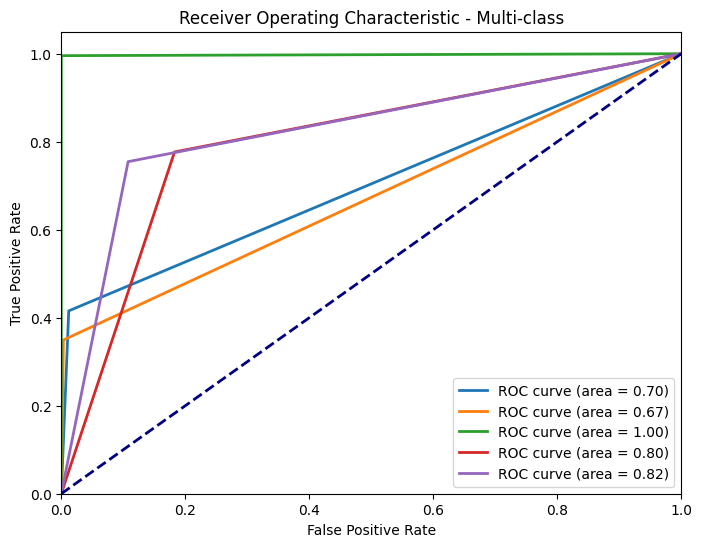

In [ ]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test_classes[:, i], y_pred_classes[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(5):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Multi-class')
plt.legend(loc='lower right')
plt.show()

## without scaler

In [25]:
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, confusion_matrix, accuracy_score
K=np.arange(2, 100, 1)
accuracies=[]
MARs=[]
FARs=[]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


for i,ki in enumerate(K):
  MAR=0
  FAR=0
  knn = KNNClassifier(k=ki)
  knn.fit(X_train,y_train)
  y_pred = knn.predict(X_test)
  conf_k = confusion_matrix(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy)

  TP = np.diag(conf_k)
  FN = np.sum(conf_k, axis=1) - TP
  FP = np.sum(conf_k, axis=0) - TP
  TN = np.sum(conf_k) - TP - FP - FN
  MAR = np.mean(FN / (FN + TP))
  FAR = np.mean((FP + np.transpose(FP)) / (FP + np.transpose(FP) + TN))
  MARs.append(MAR)
  FARs.append(FAR)




The Maximum accuracy is for k=17 with acc=0.6271994134897361


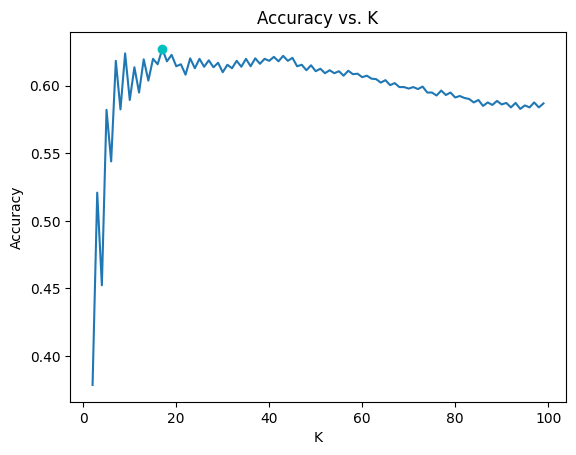

In [26]:
print("The Maximum accuracy is for k={0} with acc={1}".format(K[np.argmax(accuracies)],np.max(accuracies)))
fig, ax = plt.subplots()
plt.plot(K, accuracies)
plt.plot(K[np.argmax(accuracies)],np.max(accuracies),'co')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K')
# plt.legend()
plt.show()

Test AUC: 0.6988807792062964
Test Recall: 0.6271994134897361
Test F1-score: 0.6271994134897361
Test Precision: 0.6271994134897361
Confusion Matrix:


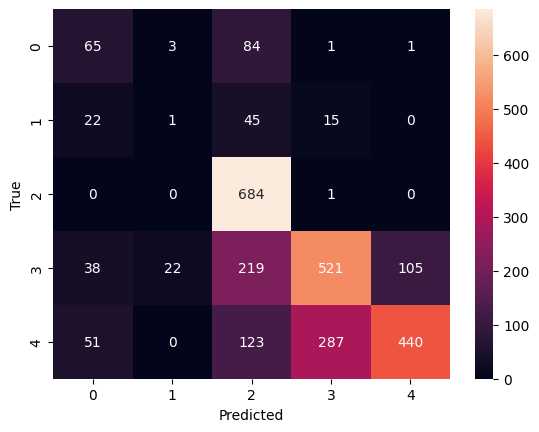

In [27]:
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, confusion_matrix
from keras.utils import to_categorical

knn1 = KNNClassifier(k=17)
knn1.fit(X_train,y_train)
y_pred = knn1.predict(X_test)

y_pred_classes = np.round(y_pred)
y_pred_classes = to_categorical(y_pred_classes, 5)
y_test_classes= to_categorical(y_test, 5)

auc_score = roc_auc_score(y_test_classes, y_pred_classes, multi_class='ovr')
recall = recall_score(y_test_classes, y_pred_classes, average='micro')
f1 = f1_score(y_test_classes, y_pred_classes, average='micro')
precision = precision_score(y_test_classes, y_pred_classes, average='micro')
print('Test AUC:', auc_score)
print('Test Recall:', recall)
print('Test F1-score:', f1)
print('Test Precision:', precision)


cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

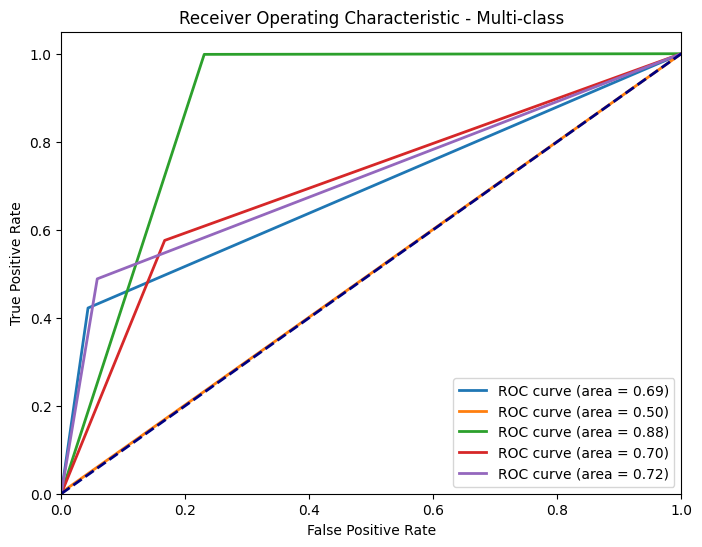

In [28]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test_classes[:, i], y_pred_classes[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(5):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Multi-class')
plt.legend(loc='lower right')
plt.show()

# NN

## with scaler

In [10]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

input_shape=x_train[0].shape

num_classes = np.unique(y).shape[0]
print(num_classes)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=input_shape))
model.add(Dense(16,activation='elu'))
model.add(Dense(8,activation='elu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()



import keras
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

start_time = time.time()

history= model.fit(x_train, y_train , batch_size=32, epochs=30, validation_data=(x_test, y_test))

end_time = time.time()
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))

5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                224       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
Total params: 933
Trainable params: 933
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
597/597 [==============================] - 7s 5ms/step - loss: 0.4891 - accuracy: 0.7924 - val_loss: 0.1954 - val_accuracy: 0.9216
Epoch 2/30
597/597 [==========================

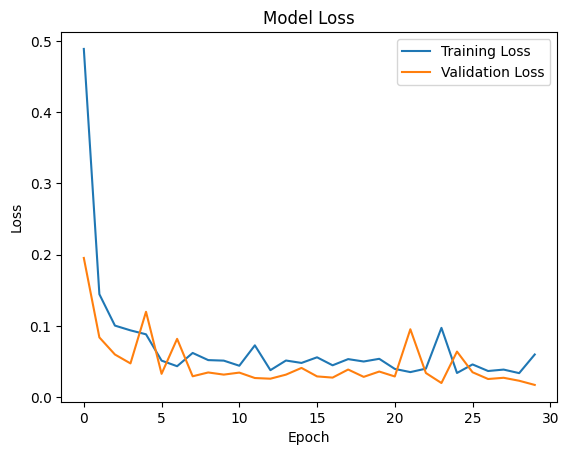

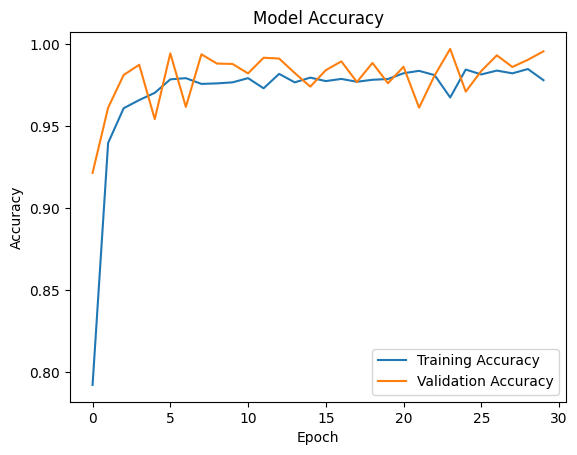

256/256 [==============================] - 1s 2ms/step - loss: 0.0170 - accuracy: 0.9956
Test loss: 0.0169823057949543
Test accuracy: 0.9956011772155762


In [11]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss, accuracy = model.evaluate(x_test, y_test, batch_size=32)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

256/256 [==============================] - 0s 2ms/step
Test AUC: 0.9979805667660994
Test Recall: 0.9956011730205279
Test F1-score: 0.9956011730205279
Test Precision: 0.9956011730205279
Confusion Matrix:


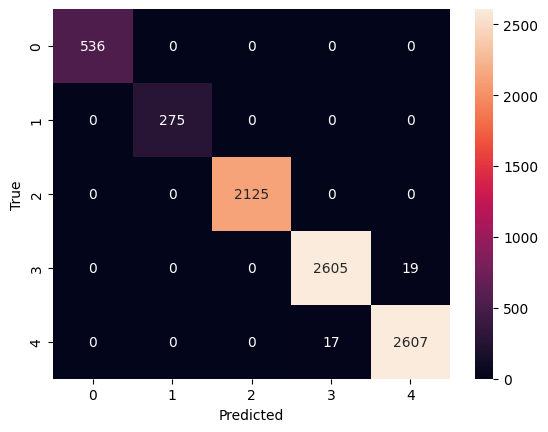

In [12]:
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, confusion_matrix

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
y_pred = model.predict(x_test)
y_pred_classes = np.round(y_pred)

from keras.utils import to_categorical
y_test_classes= to_categorical(y_test, num_classes)
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
auc_score = roc_auc_score(y_test_classes, y_pred_classes, multi_class='ovr')
recall = recall_score(y_test_classes, y_pred_classes, average='micro')
f1 = f1_score(y_test_classes, y_pred_classes, average='micro')
precision = precision_score(y_test_classes, y_pred_classes, average='micro')
print('Test AUC:', auc_score)
print('Test Recall:', recall)
print('Test F1-score:', f1)
print('Test Precision:', precision)

y_test_bin = np.argmax(y_test_classes, axis=1)
y_pred_bin = np.argmax(y_pred_classes, axis=1)
cm = confusion_matrix(y_test_bin, y_pred_bin)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

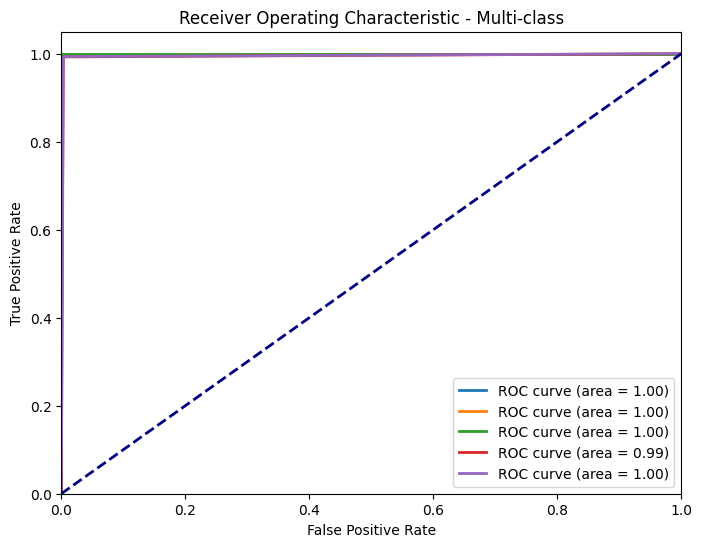

In [13]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_classes[:, i], y_pred_classes[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Multi-class')
plt.legend(loc='lower right')
plt.show()

## without scaler

In [33]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)


input_shape=x_train[0].shape

num_classes = np.unique(y).shape[0]

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=input_shape))
model.add(Dense(16,activation='elu'))
model.add(Dense(8,activation='elu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()



import keras
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

start_time = time.time()

history= model.fit(x_train, y_train , batch_size=32, epochs=30, validation_data=(x_test, y_test))

end_time = time.time()
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 32)                224       
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dense_20 (Dense)            (None, 8)                 136       
                                                                 
 dense_21 (Dense)            (None, 5)                 45        
                                                                 
Total params: 933
Trainable params: 933
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
597/597 [==============================] - 3s 4ms/step - loss: 2.1709 - accuracy: 0.3082 - val_loss: 1.3738 - val_accuracy: 0.3206
Epoch 2/30
597/597 [==========================

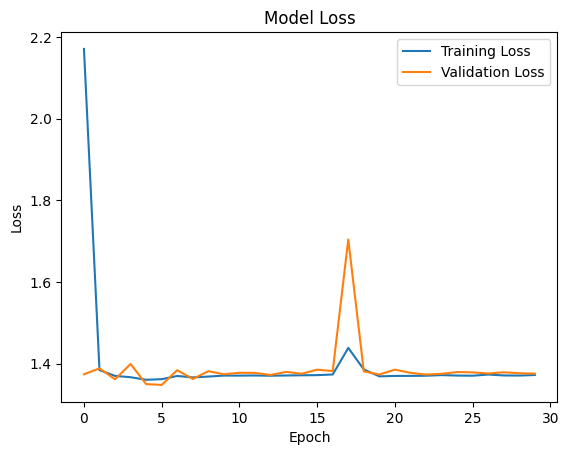

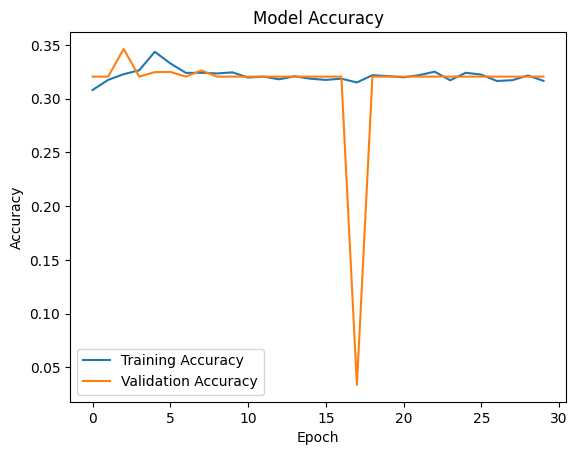

256/256 [==============================] - 1s 2ms/step - loss: 1.3753 - accuracy: 0.3206
Test loss: 1.3753368854522705
Test accuracy: 0.3206256031990051


In [34]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss, accuracy = model.evaluate(x_test, y_test, batch_size=32)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

256/256 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test AUC: 0.5
Test Recall: 0.0
Test F1-score: 0.0
Test Precision: 0.0
Confusion Matrix:


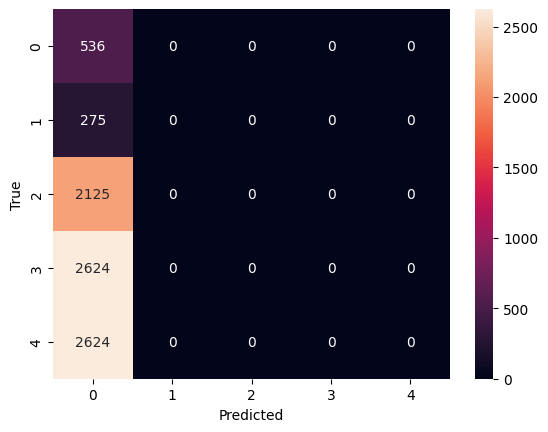

In [35]:
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, confusion_matrix

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
y_pred = model.predict(x_test)
y_pred_classes = np.round(y_pred)

from keras.utils import to_categorical
y_test_classes= to_categorical(y_test, num_classes)
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
auc_score = roc_auc_score(y_test_classes, y_pred_classes, multi_class='ovr')
recall = recall_score(y_test_classes, y_pred_classes, average='micro')
f1 = f1_score(y_test_classes, y_pred_classes, average='micro')
precision = precision_score(y_test_classes, y_pred_classes, average='micro')
print('Test AUC:', auc_score)
print('Test Recall:', recall)
print('Test F1-score:', f1)
print('Test Precision:', precision)

y_test_bin = np.argmax(y_test_classes, axis=1)
y_pred_bin = np.argmax(y_pred_classes, axis=1)
cm = confusion_matrix(y_test_bin, y_pred_bin)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

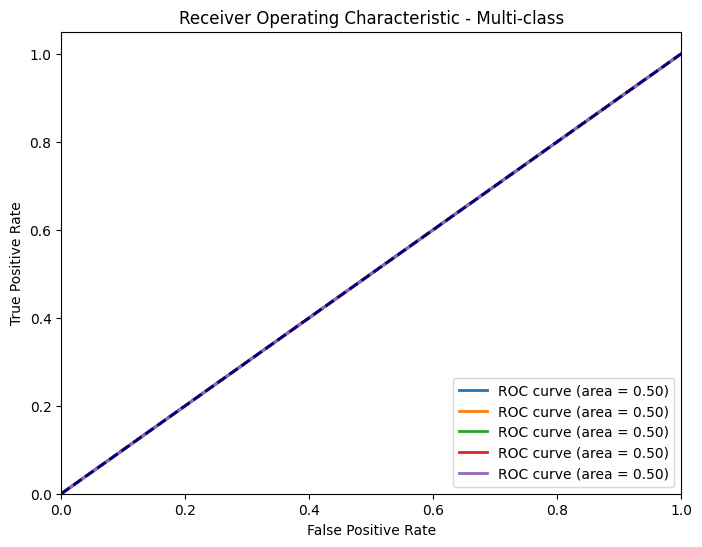

In [36]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_classes[:, i], y_pred_classes[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Multi-class')
plt.legend(loc='lower right')
plt.show()

## NN on LDA

In [16]:
import numpy as np
from tensorflow.keras.models import Sequential
x_train, x_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.3, random_state=21)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


input_shape=x_train[0].shape

num_classes = np.unique(y).shape[0]

model = Sequential()
model.add(Dense(64, activation='elu', input_shape=input_shape))
model.add(Dense(32,activation='elu'))
model.add(Dense(16,activation='elu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


# Define the optimizer and compile the model
import keras
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

start_time = time.time()

history= model.fit(x_train, y_train , batch_size=32, epochs=100, validation_data=(x_test, y_test))

# Calculate the elapsed time
end_time = time.time()
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                192       
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 5)                 85        
                                                                 
Total params: 2,885
Trainable params: 2,885
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
597/597 [==============================] - 3s 4ms/step - loss: 0.7004 - accuracy: 0.6548 - val_loss: 0.5997 - val_accuracy: 0.6920
Epoch 2/100
597/597 [====================

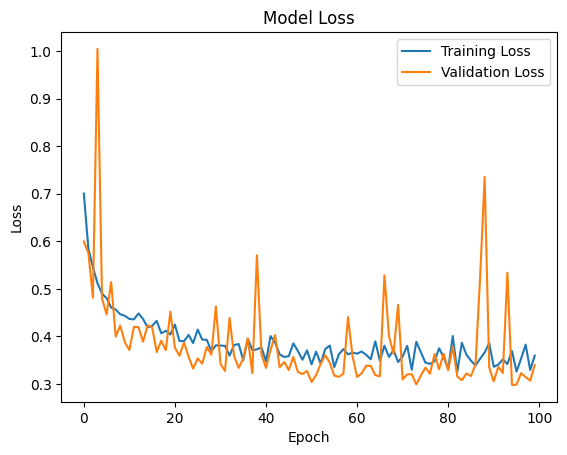

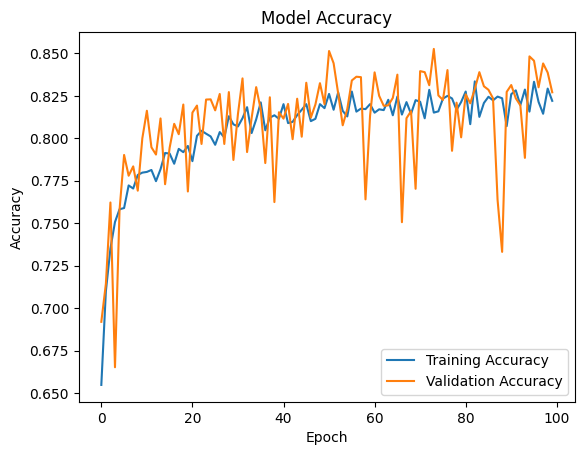

256/256 [==============================] - 1s 2ms/step - loss: 0.3398 - accuracy: 0.8271
Test loss: 0.3398248553276062
Test accuracy: 0.8271016478538513


In [17]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss, accuracy = model.evaluate(x_test, y_test, batch_size=32)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

256/256 [==============================] - 0s 1ms/step
Test AUC: 0.9182208046431706
Test Recall: 0.8256353861192571
Test F1-score: 0.8262916539284623
Test Precision: 0.8269489658548526
Confusion Matrix:


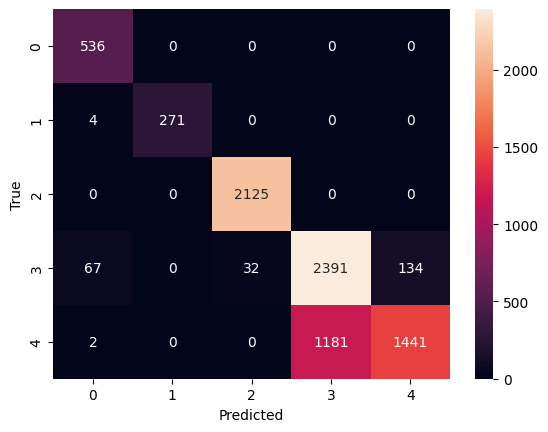

In [18]:
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, confusion_matrix
# Evaluate the model on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
y_pred = model.predict(x_test)
y_pred_classes = np.round(y_pred)
# print(y_pred_classes)
from keras.utils import to_categorical
y_test_classes= to_categorical(y_test, num_classes)
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
auc_score = roc_auc_score(y_test_classes, y_pred_classes, multi_class='ovr')
recall = recall_score(y_test_classes, y_pred_classes, average='micro')
f1 = f1_score(y_test_classes, y_pred_classes, average='micro')
precision = precision_score(y_test_classes, y_pred_classes, average='micro')
print('Test AUC:', auc_score)
print('Test Recall:', recall)
print('Test F1-score:', f1)
print('Test Precision:', precision)

y_test_bin = np.argmax(y_test_classes, axis=1)
y_pred_bin = np.argmax(y_pred_classes, axis=1)
cm = confusion_matrix(y_test_bin, y_pred_bin)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

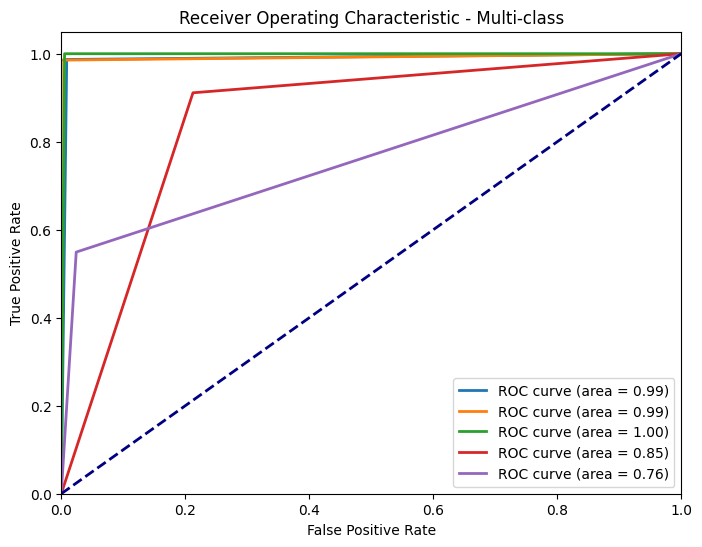

In [19]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_classes[:, i], y_pred_classes[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Multi-class')
plt.legend(loc='lower right')
plt.show()

# Transformer

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

# Normalize the input features
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Define the Transformer Encoder architecture
def transformer_encoder(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Dense(64, activation='elu')(inputs)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.2)(x)
    x = Dense(8, activation='elu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define the model
input_shape = x_train.shape[1:]
num_classes = len(np.unique(y))
model = transformer_encoder(input_shape, num_classes)
model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.008)
model.compile(loss=SparseCategoricalCrossentropy(), optimizer=optimizer, metrics=[SparseCategoricalAccuracy()])

# Define early stopping criteria
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, batch_size=16, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


In [ ]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over epochs
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# loss, accuracy = model.evaluate(x_test, y_test, batch_size=32)
# print('Test loss:', loss)
# print('Test accuracy:', accuracy)

In [ ]:
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, confusion_matrix
# Evaluate the model on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
y_pred = model.predict(x_test)
y_pred_classes = np.round(y_pred)
# print(y_pred_classes)
from keras.utils import to_categorical
y_test_classes= to_categorical(y_test, num_classes)
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
auc_score = roc_auc_score(y_test_classes, y_pred_classes, multi_class='ovr')
recall = recall_score(y_test_classes, y_pred_classes, average='micro')
f1 = f1_score(y_test_classes, y_pred_classes, average='micro')
precision = precision_score(y_test_classes, y_pred_classes, average='micro')
print('Test AUC:', auc_score)
print('Test Recall:', recall)
print('Test F1-score:', f1)
print('Test Precision:', precision)

y_test_bin = np.argmax(y_test_classes, axis=1)
y_pred_bin = np.argmax(y_pred_classes, axis=1)
cm = confusion_matrix(y_test_bin, y_pred_bin)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
# plt.savefig('conf.pdf')
plt.show()

# CNN

## with scaler

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(6, 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 2, activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

import keras
opt = keras.optimizers.Adam(learning_rate=0.006)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])



start_time = time.time()

history = model.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test))

end_time = time.time()
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 4, 64)             256       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 1, 32)             4128      
                                                                 
 flatten_3 (Flatten)         (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 16)                528       
                                                                 
 dense_27 (Dense)            (None, 5)                 85        
                                                      

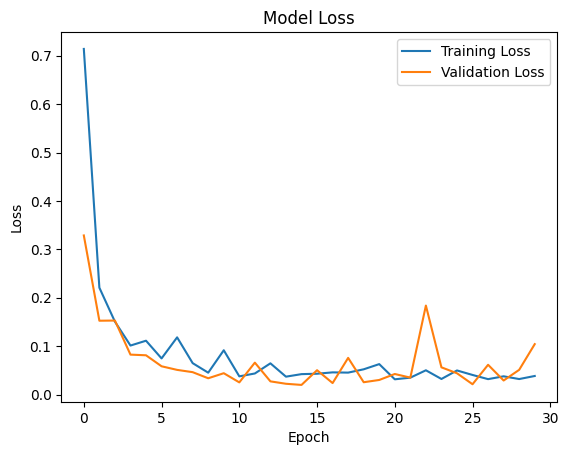

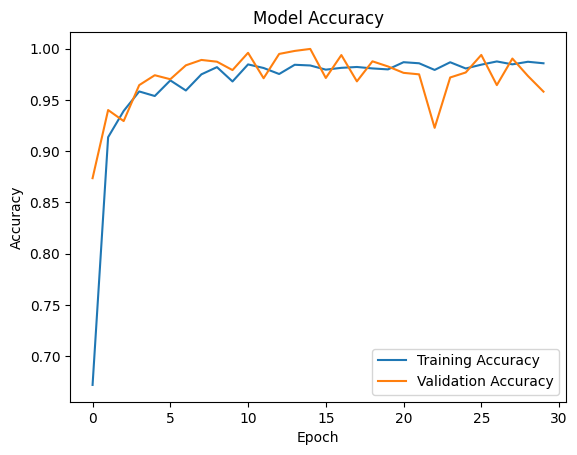

256/256 [==============================] - 1s 3ms/step - loss: 0.1042 - accuracy: 0.9581
Test loss: 0.10423263162374496
Test accuracy: 0.9580889344215393


In [40]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss, accuracy = model.evaluate(x_test, y_test, batch_size=32)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

256/256 [==============================] - 0s 2ms/step
Test AUC: 0.9800722513734484
Test Recall: 0.958088954056696
Test F1-score: 0.9581474919044419
Test Precision: 0.9582060369057803
Confusion Matrix:


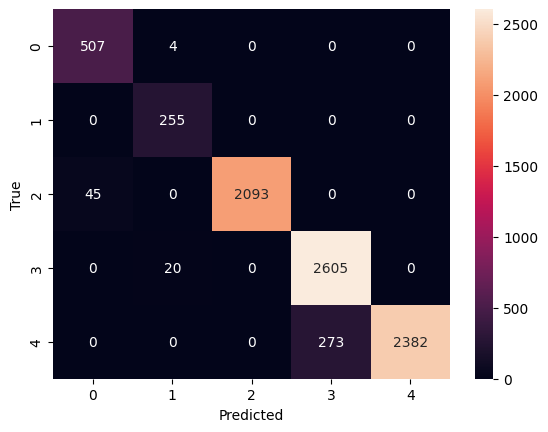

In [41]:
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, confusion_matrix
# Evaluate the model on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
y_pred = model.predict(x_test)
y_pred_classes = np.round(y_pred)

from keras.utils import to_categorical
y_test_classes= to_categorical(y_test, num_classes)
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
auc_score = roc_auc_score(y_test_classes, y_pred_classes, multi_class='ovr')
recall = recall_score(y_test_classes, y_pred_classes, average='micro')
f1 = f1_score(y_test_classes, y_pred_classes, average='micro')
precision = precision_score(y_test_classes, y_pred_classes, average='micro')
print('Test AUC:', auc_score)
print('Test Recall:', recall)
print('Test F1-score:', f1)
print('Test Precision:', precision)

y_test_bin = np.argmax(y_test_classes, axis=1)
y_pred_bin = np.argmax(y_pred_classes, axis=1)
cm = confusion_matrix(y_test_bin, y_pred_bin)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

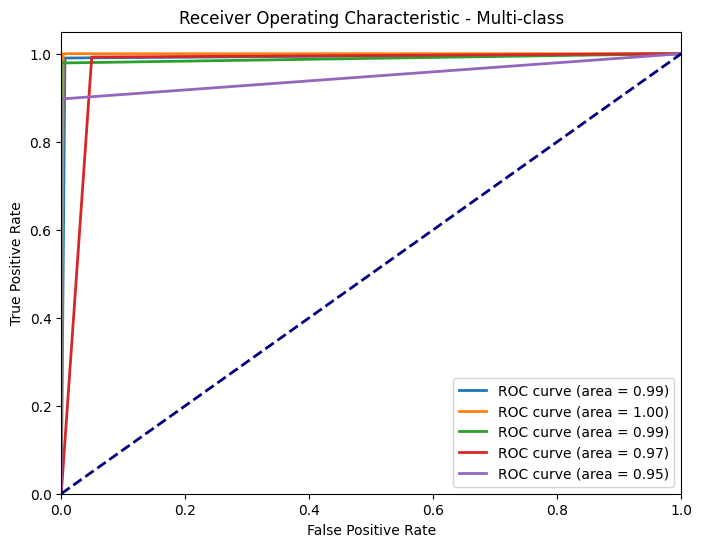

In [42]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_classes[:, i], y_pred_classes[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Multi-class')
plt.legend(loc='lower right')
plt.show()

## without scaler

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(6, 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 2, activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

import keras
opt = keras.optimizers.Adam(learning_rate=0.006)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

start_time = time.time()

history = model.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test))

end_time = time.time()
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 4, 64)             256       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 1, 32)             4128      
                                                                 
 flatten_4 (Flatten)         (None, 32)                0         
                                                                 
 dense_28 (Dense)            (None, 16)                528       
                                                                 
 dense_29 (Dense)            (None, 5)                 85        
                                                      

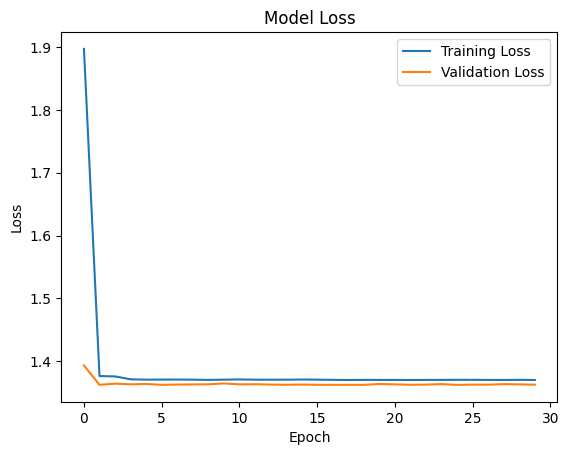

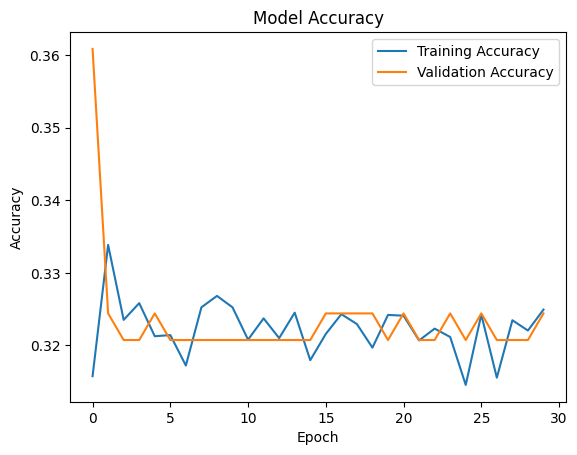

256/256 [==============================] - 1s 2ms/step - loss: 1.3623 - accuracy: 0.3244
Test loss: 1.3622843027114868
Test accuracy: 0.3244134783744812


In [44]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss, accuracy = model.evaluate(x_test, y_test, batch_size=32)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

256/256 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test AUC: 0.5
Test Recall: 0.0
Test F1-score: 0.0
Test Precision: 0.0
Confusion Matrix:


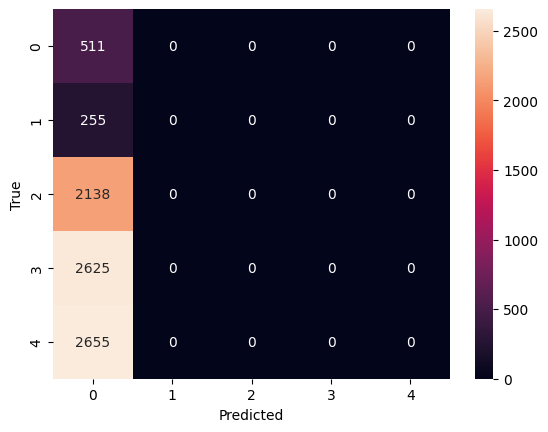

In [45]:
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, confusion_matrix
# Evaluate the model on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
y_pred = model.predict(x_test)
y_pred_classes = np.round(y_pred)

from keras.utils import to_categorical
y_test_classes= to_categorical(y_test, num_classes)
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
auc_score = roc_auc_score(y_test_classes, y_pred_classes, multi_class='ovr')
recall = recall_score(y_test_classes, y_pred_classes, average='micro')
f1 = f1_score(y_test_classes, y_pred_classes, average='micro')
precision = precision_score(y_test_classes, y_pred_classes, average='micro')
print('Test AUC:', auc_score)
print('Test Recall:', recall)
print('Test F1-score:', f1)
print('Test Precision:', precision)

y_test_bin = np.argmax(y_test_classes, axis=1)
y_pred_bin = np.argmax(y_pred_classes, axis=1)
cm = confusion_matrix(y_test_bin, y_pred_bin)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

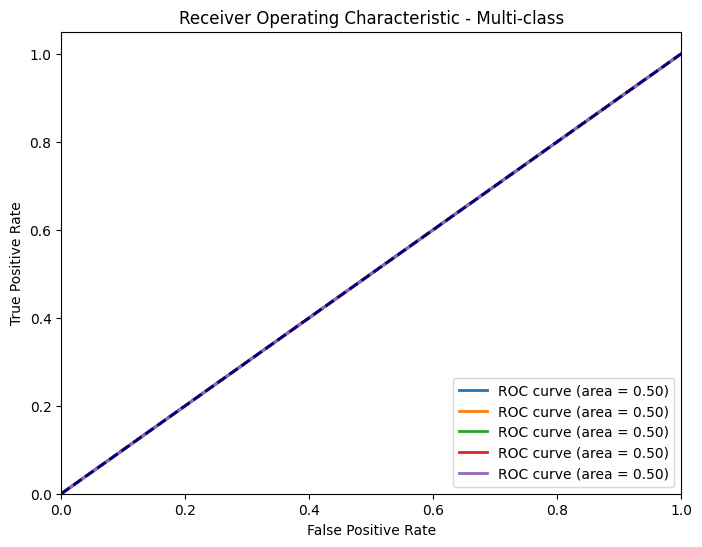

In [46]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_classes[:, i], y_pred_classes[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Multi-class')
plt.legend(loc='lower right')
plt.show()

# LSTM+CNN

## with scaler

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout
from keras.regularizers import l2
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(6, 1)))
model.add(MaxPooling1D(2))
model.add(LSTM(16))
model.add(Dense(num_classes, activation='softmax'))
model.summary()



# Define the optimizer and compile the model
import keras
opt = keras.optimizers.Adam(learning_rate=0.04)

# Compile and train the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

start_time = time.time()

history = model.fit(x_train, y_train, batch_size=32, epochs=40, validation_data=(x_test, y_test))

# Calculate the elapsed time
end_time = time.time()
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 4, 32)             128       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 2, 32)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense_30 (Dense)            (None, 5)                 85        
                                                                 
Total params: 3,349
Trainable params: 3,349
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
597/597 [==============================] - 7s 6ms/step - loss: 0.7798 - accuracy: 0.6713 - val_loss: 0.644

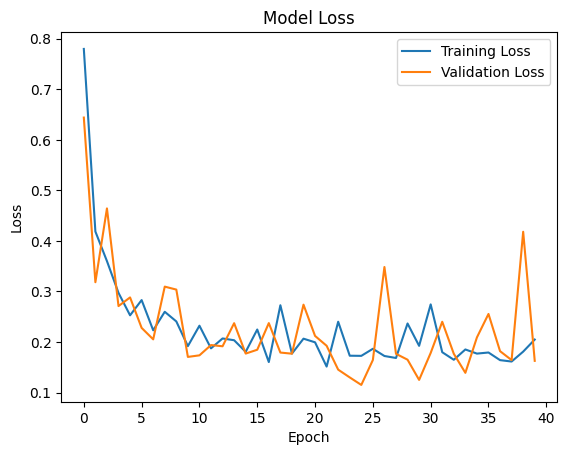

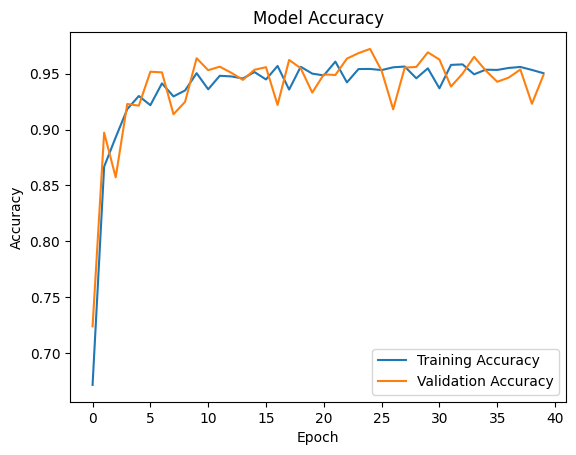

256/256 [==============================] - 1s 3ms/step - loss: 0.1627 - accuracy: 0.9489
Test loss: 0.16273760795593262
Test accuracy: 0.948924720287323


In [48]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss, accuracy = model.evaluate(x_test, y_test, batch_size=32)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

256/256 [==============================] - 1s 3ms/step
Test AUC: 0.9724877720903026
Test Recall: 0.9488025415444771
Test F1-score: 0.948976474182707
Test Precision: 0.9491504706026158
Confusion Matrix:


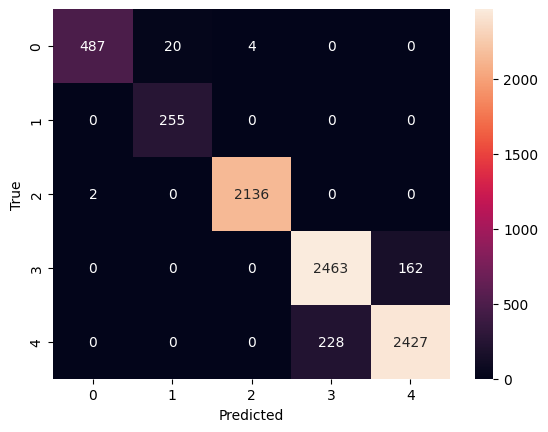

In [49]:
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, confusion_matrix

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
y_pred = model.predict(x_test)
y_pred_classes = np.round(y_pred)
from keras.utils import to_categorical
y_test_classes= to_categorical(y_test, num_classes)
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
auc_score = roc_auc_score(y_test_classes, y_pred_classes, multi_class='ovr')
recall = recall_score(y_test_classes, y_pred_classes, average='micro')
f1 = f1_score(y_test_classes, y_pred_classes, average='micro')
precision = precision_score(y_test_classes, y_pred_classes, average='micro')
print('Test AUC:', auc_score)
print('Test Recall:', recall)
print('Test F1-score:', f1)
print('Test Precision:', precision)

y_test_bin = np.argmax(y_test_classes, axis=1)
y_pred_bin = np.argmax(y_pred_classes, axis=1)
cm = confusion_matrix(y_test_bin, y_pred_bin)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

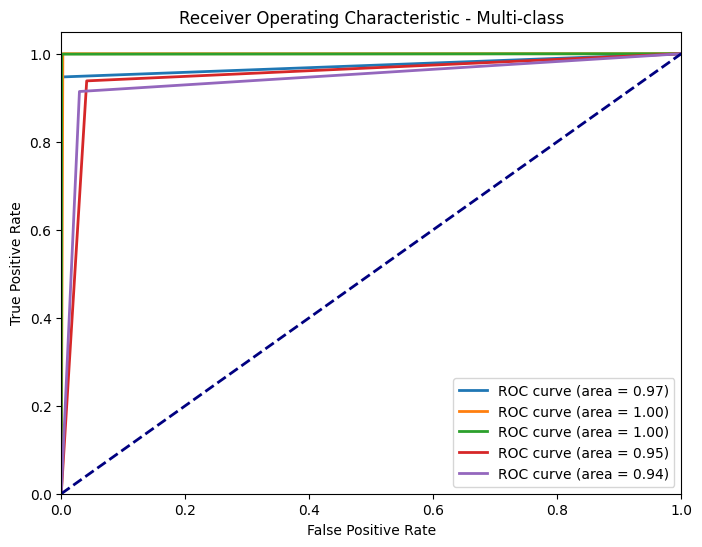

In [50]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_classes[:, i], y_pred_classes[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Multi-class')
plt.legend(loc='lower right')
plt.show()

## without scaler

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout
from keras.regularizers import l2
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(6, 1)))
model.add(MaxPooling1D(2))
model.add(LSTM(16))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


# Define the optimizer and compile the model
import keras
opt = keras.optimizers.Adam(learning_rate=0.04)

# Compile and train the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

start_time = time.time()

history = model.fit(x_train, y_train, batch_size=32, epochs=40, validation_data=(x_test, y_test))

# Calculate the elapsed time
end_time = time.time()
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 4, 32)             128       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 2, 32)            0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_31 (Dense)            (None, 5)                 85        
                                                                 
Total params: 3,349
Trainable params: 3,349
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
597/597 [==============================] - 5s 6ms/step - loss: 1.3873 - accuracy: 0.3159 - val_loss: 1.397

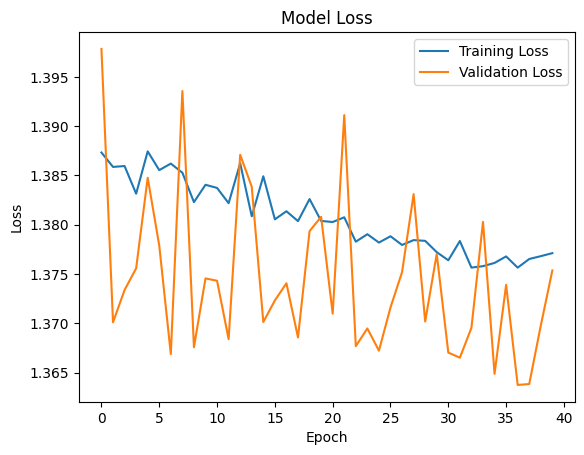

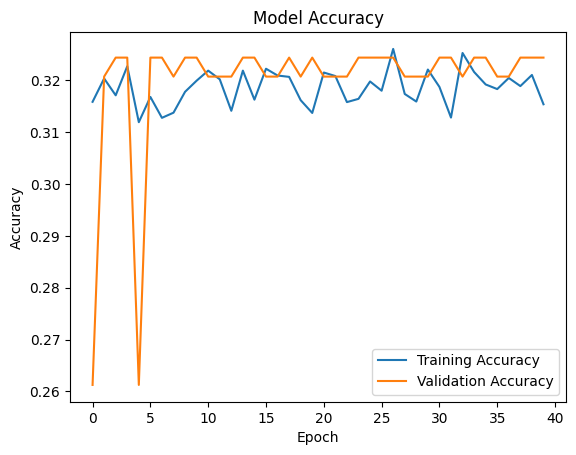

256/256 [==============================] - 1s 4ms/step - loss: 1.3754 - accuracy: 0.3244
Test loss: 1.3753589391708374
Test accuracy: 0.3244134783744812


In [52]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss, accuracy = model.evaluate(x_test, y_test, batch_size=32)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

256/256 [==============================] - 1s 2ms/step
Test AUC: 0.5
Test Recall: 0.0
Test F1-score: 0.0
Test Precision: 0.0
Confusion Matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


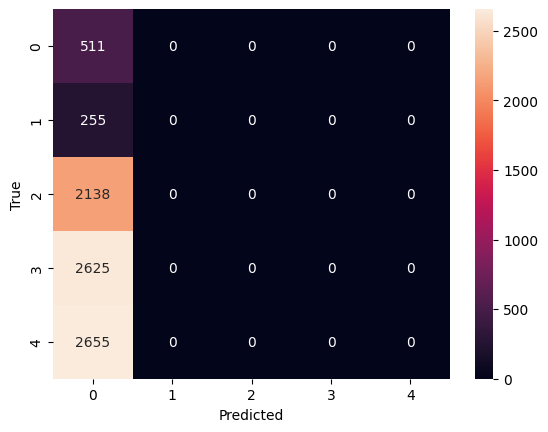

In [53]:
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, confusion_matrix

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
y_pred = model.predict(x_test)
y_pred_classes = np.round(y_pred)
from keras.utils import to_categorical
y_test_classes= to_categorical(y_test, num_classes)
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
auc_score = roc_auc_score(y_test_classes, y_pred_classes, multi_class='ovr')
recall = recall_score(y_test_classes, y_pred_classes, average='micro')
f1 = f1_score(y_test_classes, y_pred_classes, average='micro')
precision = precision_score(y_test_classes, y_pred_classes, average='micro')
print('Test AUC:', auc_score)
print('Test Recall:', recall)
print('Test F1-score:', f1)
print('Test Precision:', precision)

y_test_bin = np.argmax(y_test_classes, axis=1)
y_pred_bin = np.argmax(y_pred_classes, axis=1)
cm = confusion_matrix(y_test_bin, y_pred_bin)
print("Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

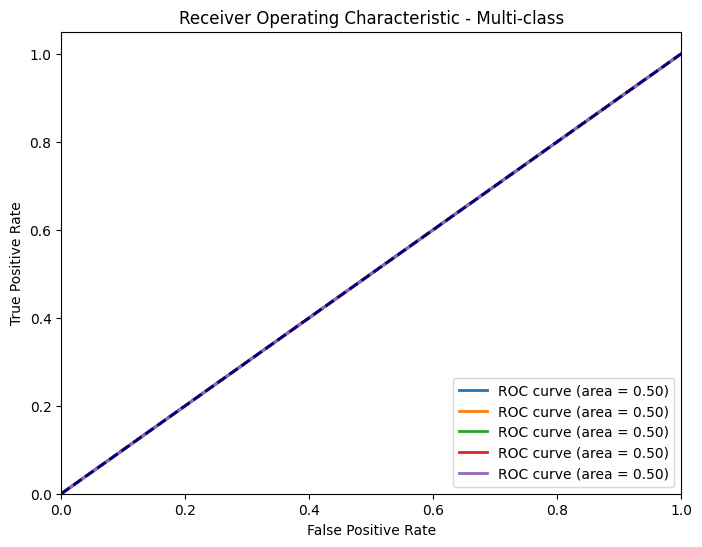

In [54]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_classes[:, i], y_pred_classes[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Multi-class')
plt.legend(loc='lower right')
plt.show()